## 세션 기반 추천시스템: 다음에 볼 영화 예측

### 학습 목표
- 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 Session-Based Recommendation과 그 구현 과정을 이해한다.

### 루브릭 
- Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다. : **데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.**
- RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다. : **적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.**
- 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다. : **3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.**

## 목차
### 1. 데이터 준비 및 전처리
#### 1) Session length 분석
#### 2) Session time, cleansing
#### 3) 미니 배치 구성
### 2. 모델 구성 및 테스트
#### 1) 시간 전처리만 실행
#### 2) Item len 제한
#### 3) Session 정의 변경
#### 4) 모델 파라미터 변경
---

## 1. 데이터 준비 및 전처리

In [2]:
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### 1) Session length 분석

In [4]:
print('유저 수:', data['UserId'].nunique())
print('영화 수:', data['ItemId'].nunique())

유저 수: 6040
영화 수: 3706


In [5]:
Item_len = data.groupby('ItemId').size()
Item_len

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

영화가 클릭된 횟수를 Item_len에 저장

In [6]:
print('영화 당 클릭 수의 평균:', Item_len.mean())
print('영화 당 클릭 수의 최댓값:', Item_len.max())
print('영화 당 클릭 수의 최솟값:', Item_len.min())

영화 당 클릭 수의 평균: 269.88909875876953
영화 당 클릭 수의 최댓값: 3428
영화 당 클릭 수의 최솟값: 1


영화 당 클릭 수 Q1: 33.0
영화 당 클릭 수 Q2(중앙값): 123.5
영화 당 클릭 수 Q3: 350.0


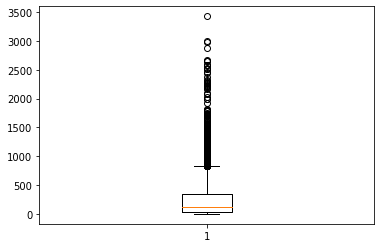

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.boxplot([Item_len])

print('영화 당 클릭 수 Q1:', Item_len.quantile(0.25))
print('영화 당 클릭 수 Q2(중앙값):', Item_len.quantile(0.50))
print('영화 당 클릭 수 Q3:', Item_len.quantile(0.75))

In [8]:
# upper whisker = 350 + (350-33)*1.5 = 825.5
print('인기 영화 갯수:',Item_len[Item_len > 825.5].count())
print('한번 클릭된 영화 갯수:',Item_len[Item_len == 1].count())

인기 영화 갯수: 296
한번 클릭된 영화 갯수: 114


영화마다 클릭된 수의 편차가 크다. 3,706편의 영화 중 대다수는 클릭 수가 적고, 약 296개, 일부의 영화만이 많은 클릭수를 보유하고 있는 인기영화라고 할 수 있다. 한번 클릭되었을 뿐인 영화는 114개로, 추천 시스템에서는 제외하는 것이 좋을 수 있다.

In [9]:
User_len = data.groupby('UserId').count().loc[:,'ItemId']
User_len

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Name: ItemId, Length: 6040, dtype: int64

유저당 몇개의 영화를 보았는지  User_len 시리즈에 저장

In [10]:
print('유저 당 관람한 영화 수의 평균:', User_len.mean())
print('유저 당 관람한 영화 수의 중앙값:', User_len.median())
print('유저 당 관람한 영화 수의 최댓값:', User_len.max())
print('유저 당 관람한 영화 수의 최솟값:', User_len.min())

유저 당 관람한 영화 수의 평균: 165.5975165562914
유저 당 관람한 영화 수의 중앙값: 96.0
유저 당 관람한 영화 수의 최댓값: 2314
유저 당 관람한 영화 수의 최솟값: 20


유저 당 관람한 영화 수의 편차가 심한 편이다.    
Session-Based Recommendation에서는 유저가 생성한 시간 데이터를 기준으로 Session 데이터를 생성해야 한다. '**UserId'가 같고, 'Time'이 같은 데이터를 하나의 Session이라고 가정**한다. 예를 들어 data의 index 22,27,37은 'UserId'가 1이고 'Time'이 978300055로 같으므로, 같은 Session이라고 간주한다.

In [11]:
data.index = np.array(range(1000209))    # index 재정렬
data

,UserId,ItemId,Rating,Time
0,1,3186,4,978300019
1,1,1270,5,978300055
2,1,1721,4,978300055
3,1,1022,5,978300055
4,1,2340,3,978300103
...,...,...,...,...
1000204,6040,2917,4,997454429
1000205,6040,1921,4,997454464
1000206,6040,1784,3,997454464
1000207,6040,161,3,997454486


In [12]:
SessionId =[0]
num = 0

for i in range(1,len(data)):
    if (data.loc[i,'UserId'] == data.loc[i-1,'UserId']) & (data.loc[i,'Time'] == data.loc[i-1,'Time']):
        SessionId.append(num)
    else:
        num += 1
        SessionId.append(num)
        
data.loc[:,'SessionId'] = SessionId
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


In [13]:
Session_len = data.groupby('SessionId').count().loc[:,'ItemId']
Session_len

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Name: ItemId, Length: 471163, dtype: int64

세션 당 몇개의 영화를 클릭했는지  Session_len 시리즈에 저장

In [14]:
print('세션 당 클릭한 영화 수의 평균:', Session_len.mean())
print('세션 당 클릭한 영화 수의 최댓값:', Session_len.max())
print('세션 당 클릭한 영화 수의 최솟값:', Session_len.min())

세션 당 클릭한 영화 수의 평균: 2.1228513274599234
세션 당 클릭한 영화 수의 최댓값: 30
세션 당 클릭한 영화 수의 최솟값: 1


세션 당 클릭한 영화 수 Q1: 1.0
세션 당 클릭한 영화 수 Q2(중앙값): 2.0
세션 당 클릭한 영화 수 Q3: 3.0


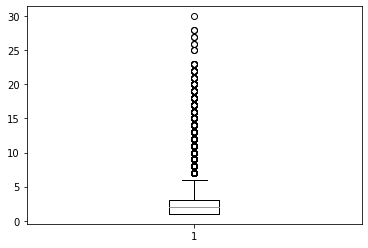

In [15]:
fig, ax = plt.subplots()

ax.boxplot([Session_len])

print('세션 당 클릭한 영화 수 Q1:', Session_len.quantile(0.25))
print('세션 당 클릭한 영화 수 Q2(중앙값):', Session_len.quantile(0.50))
print('세션 당 클릭한 영화 수 Q3:', Session_len.quantile(0.75))

In [16]:
length_count = Session_len.groupby(Session_len).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

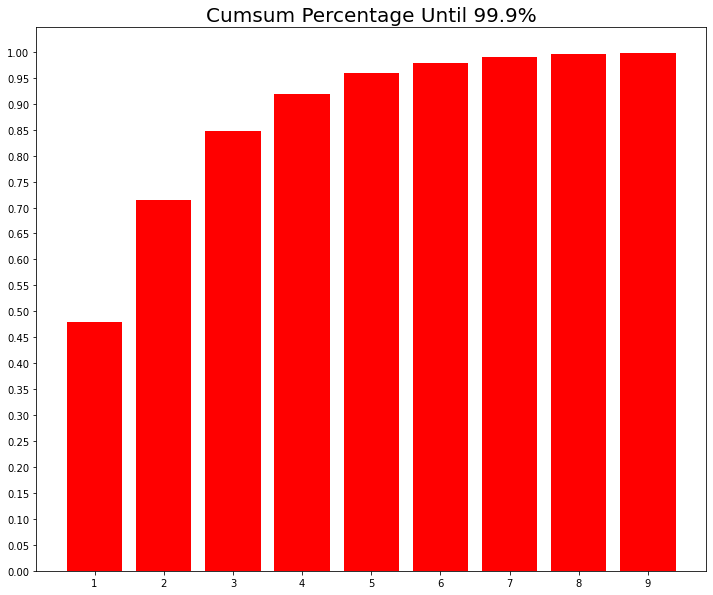

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 99.9%', size=20)
plt.show()

In [18]:
print('이상치 갯수:',Session_len[Session_len > 9].count())

이상치 갯수: 1129


세션 당 클릭한 영화 수는 절대 다수가 3개 이하 수준이다. 99.9%의 세션은 세션 당 9개 이하의 영화를 클릭했는데, 그보다 많은 세션을 이상치(비정상적인 활동)라고 가정하면 전체 471,163개 세션 중 이상치는 1,129개이다.

### 2) Session time, cleansing

In [19]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [20]:
print((latest-oldest)/3600/24/365)

2.8459746955859972


약 2.84년 분량의 데이터

In [21]:
year_ago = latest - (3600*24*365)    # 최근 일년까지
data_year_ago = data[data['Time'] > year_ago]
data_year_ago

,UserId,ItemId,Rating,Time,SessionId
5333,36,1387,5,1015904819,2791
5334,36,1201,4,1015904819,2791
5335,36,1291,5,1015904836,2792
5336,36,2167,5,1015904905,2793
5337,36,2951,4,1015904905,2793
...,...,...,...,...,...
992789,5996,3835,3,1020113184,468261
992790,5996,2422,3,1020113225,468262
992791,5996,168,3,1031058746,468263
992792,5996,339,4,1033997079,468264


In [22]:
def cleanse_recursive(data: pd.DataFrame, shortest) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest): 
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data

In [23]:
data_cleanned = cleanse_recursive(data_year_ago, shortest=2)    # 세션 당 1개의 클릭 수로는 예측에 쓸 수 없음
data_cleanned

,UserId,ItemId,Rating,Time,SessionId
5333,36,1387,5,1015904819,2791
5334,36,1201,4,1015904819,2791
5336,36,2167,5,1015904905,2793
5337,36,2951,4,1015904905,2793
5338,36,2115,5,1015904905,2793
...,...,...,...,...,...
992778,5996,2375,3,1020111221,468252
992779,5996,2616,3,1020111375,468253
992780,5996,3707,5,1020111375,468253
992781,5996,781,5,1020111524,468254


In [24]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (3600*24*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (3600*24*n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

총 1년(365일)의 데이터 중 마지막 보름(15일)씩을 train, train 직전의 보름(15일)씩을 validation set으로 분리

In [25]:
tr, test = split_by_date(data_cleanned, n_days=15)
tr, val = split_by_date(tr, n_days=15)

In [26]:
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')
    
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 9654
	 Sessions: 3489
	 Items: 2313
	 First Time : 1014924099
	 Last Time : 1043799114

* valid Set Stats Info
	 Events: 439
	 Sessions: 185
	 Items: 374
	 First Time : 1043869016
	 Last Time : 1045103679

* test Set Stats Info
	 Events: 302
	 Sessions: 118
	 Items: 284
	 First Time : 1045159856
	 Last Time : 1046454548



In [27]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [28]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### 3) 미니 배치 구성
#### SessionDataset: 세션이 시작되는 인덱스와, 세션을 새로 인덱싱한 값을 지정하는 클래스
SessionDataset.df: 데이터프레임    
SessionDataset.click_offset: Session의 시작지점    
SessionDataset.session_idx: Session의 인덱스

In [29]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [30]:
tr_dataset = SessionDataset(tr)
tr_dataset.df

,UserId,ItemId,Rating,Time,SessionId,item_idx
5333,36,1387,5,1015904819,2791,0
5334,36,1201,4,1015904819,2791,1
5336,36,2167,5,1015904905,2793,2
5337,36,2951,4,1015904905,2793,3
5338,36,2115,5,1015904905,2793,4
...,...,...,...,...,...,...
992778,5996,2375,3,1020111221,468252,508
992779,5996,2616,3,1020111375,468253,295
992780,5996,3707,5,1020111375,468253,1718
992781,5996,781,5,1020111524,468254,1663


In [31]:
tr_dataset.click_offsets

array([   0,    2,    5, ..., 9650, 9652, 9654], dtype=int32)

In [32]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 3486, 3487, 3488])

#### SessionDataLoader: Session-Parallel mini-batch 제작

In [33]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [34]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)

In [35]:
iter_ex = iter(tr_data_loader)

In [36]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 2 5 7]
Label Item Idx are :       [1 3 6 8]
Previous Masked Input Idx are []


In [37]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 9  3 11 14]
Label Item Idx are :       [10  4 12 15]
Previous Masked Input Idx are [0 2 3]


In [38]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [16 20 12 22]
Label Item Idx are :       [17 21 13 23]
Previous Masked Input Idx are [0 1 3]


## 2. 모델 구성 및 테스트
### 1) 시간 전처리만 실행
첫번째로 사용할 데이터셋은 최근 1년간의 데이터를 기반으로 가장 마지막 보름간의 추천을 하도록 하는 시간 제한 외에는 크게 가공하지 않은 셋이다.

In [39]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [41]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [42]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [43]:
args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=50, k=20)
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(16, 1, 2313)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      354750    
_________________________________________________________________
dropout (Dropout)            (16, 50)                  0         
_________________________________________________________________
dense (Dense)                (16, 2313)                117963    
Total params: 472,713
Trainable params: 472,713
Non-trainable params: 0
_________________________________________________________________


In [44]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [45]:
train_model(model, args)

Evaluation: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


	 - Recall@20 epoch 1: 0.075000
	 - MRR@20    epoch 1: 0.014336



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.15it/s]


	 - Recall@20 epoch 2: 0.066667
	 - MRR@20    epoch 2: 0.011478



Evaluation: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


	 - Recall@20 epoch 3: 0.066667
	 - MRR@20    epoch 3: 0.010446



Evaluation: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


	 - Recall@20 epoch 4: 0.075000
	 - MRR@20    epoch 4: 0.019589



Evaluation: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


	 - Recall@20 epoch 5: 0.075000
	 - MRR@20    epoch 5: 0.023496



Evaluation: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


	 - Recall@20 epoch 6: 0.066667
	 - MRR@20    epoch 6: 0.020282



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.28it/s]


	 - Recall@20 epoch 7: 0.079167
	 - MRR@20    epoch 7: 0.022015



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.34it/s]


	 - Recall@20 epoch 8: 0.079167
	 - MRR@20    epoch 8: 0.021360



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.26it/s]


	 - Recall@20 epoch 9: 0.079167
	 - MRR@20    epoch 9: 0.023331



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.30it/s]


	 - Recall@20 epoch 10: 0.079167
	 - MRR@20    epoch 10: 0.018483



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.16it/s]


	 - Recall@20 epoch 11: 0.087500
	 - MRR@20    epoch 11: 0.023056



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.29it/s]


	 - Recall@20 epoch 12: 0.083333
	 - MRR@20    epoch 12: 0.025575



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.05it/s]


	 - Recall@20 epoch 13: 0.083333
	 - MRR@20    epoch 13: 0.027945



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.37it/s]


	 - Recall@20 epoch 14: 0.087500
	 - MRR@20    epoch 14: 0.029735



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.32it/s]


	 - Recall@20 epoch 15: 0.091667
	 - MRR@20    epoch 15: 0.034518



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.31it/s]


	 - Recall@20 epoch 16: 0.100000
	 - MRR@20    epoch 16: 0.040153



Evaluation: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


	 - Recall@20 epoch 17: 0.108333
	 - MRR@20    epoch 17: 0.039501



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.55it/s]


	 - Recall@20 epoch 18: 0.104167
	 - MRR@20    epoch 18: 0.043285



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.48it/s]


	 - Recall@20 epoch 19: 0.104167
	 - MRR@20    epoch 19: 0.043790



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.60it/s]


	 - Recall@20 epoch 20: 0.100000
	 - MRR@20    epoch 20: 0.044518



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.29it/s]


	 - Recall@20 epoch 21: 0.100000
	 - MRR@20    epoch 21: 0.045372



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.37it/s]


	 - Recall@20 epoch 22: 0.095833
	 - MRR@20    epoch 22: 0.045959



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.55it/s]


	 - Recall@20 epoch 23: 0.091667
	 - MRR@20    epoch 23: 0.046281



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.22it/s]


	 - Recall@20 epoch 24: 0.091667
	 - MRR@20    epoch 24: 0.046900



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.42it/s]


	 - Recall@20 epoch 25: 0.091667
	 - MRR@20    epoch 25: 0.046298



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.42it/s]


	 - Recall@20 epoch 26: 0.095833
	 - MRR@20    epoch 26: 0.047801



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.37it/s]


	 - Recall@20 epoch 27: 0.100000
	 - MRR@20    epoch 27: 0.048266



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.63it/s]


	 - Recall@20 epoch 28: 0.108333
	 - MRR@20    epoch 28: 0.049283



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.26it/s]


	 - Recall@20 epoch 29: 0.112500
	 - MRR@20    epoch 29: 0.048124



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.35it/s]


	 - Recall@20 epoch 30: 0.108333
	 - MRR@20    epoch 30: 0.048267



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.57it/s]


	 - Recall@20 epoch 31: 0.108333
	 - MRR@20    epoch 31: 0.046360



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.61it/s]


	 - Recall@20 epoch 32: 0.108333
	 - MRR@20    epoch 32: 0.051958



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.55it/s]


	 - Recall@20 epoch 33: 0.104167
	 - MRR@20    epoch 33: 0.051164



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.47it/s]


	 - Recall@20 epoch 34: 0.108333
	 - MRR@20    epoch 34: 0.051828



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.43it/s]


	 - Recall@20 epoch 35: 0.104167
	 - MRR@20    epoch 35: 0.051480



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.16it/s]


	 - Recall@20 epoch 36: 0.108333
	 - MRR@20    epoch 36: 0.050156



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.25it/s]


	 - Recall@20 epoch 37: 0.104167
	 - MRR@20    epoch 37: 0.050820



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.54it/s]


	 - Recall@20 epoch 38: 0.108333
	 - MRR@20    epoch 38: 0.049704



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.28it/s]


	 - Recall@20 epoch 39: 0.104167
	 - MRR@20    epoch 39: 0.048324



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.55it/s]


	 - Recall@20 epoch 40: 0.112500
	 - MRR@20    epoch 40: 0.047415



Evaluation: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


	 - Recall@20 epoch 41: 0.100000
	 - MRR@20    epoch 41: 0.047460



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.27it/s]


	 - Recall@20 epoch 42: 0.100000
	 - MRR@20    epoch 42: 0.047212



Evaluation: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


	 - Recall@20 epoch 43: 0.100000
	 - MRR@20    epoch 43: 0.046448



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.36it/s]


	 - Recall@20 epoch 44: 0.104167
	 - MRR@20    epoch 44: 0.049656



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.40it/s]


	 - Recall@20 epoch 45: 0.104167
	 - MRR@20    epoch 45: 0.047011



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.48it/s]


	 - Recall@20 epoch 46: 0.104167
	 - MRR@20    epoch 46: 0.047168



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.30it/s]


	 - Recall@20 epoch 47: 0.100000
	 - MRR@20    epoch 47: 0.047388



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.47it/s]


	 - Recall@20 epoch 48: 0.100000
	 - MRR@20    epoch 48: 0.046551



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.61it/s]


	 - Recall@20 epoch 49: 0.100000
	 - MRR@20    epoch 49: 0.046271



Evaluation: 100%|██████████| 15/15 [00:01<00:00, 10.58it/s]

	 - Recall@20 epoch 50: 0.104167
	 - MRR@20    epoch 50: 0.047326



Recall과 MRR이 점진적으로 오르기는 하나, train_loss가 떨어지는 것에 비해 미미하다. 

### 2) Item len 제한
영화들 가운데에서는 1번만 클릭되어 다음 클릭으로 이어지지 않은 영화들도 있었다. 전처리 시 이 영화들을 제거하는 작업을 추가해본다.

In [49]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data

def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [50]:
data_cleanned = cleanse_recursive(data_year_ago, shortest=2, least_click=2)
data_cleanned

,UserId,ItemId,Rating,Time,SessionId
5333,36,1387,5,1015904819,2791
5334,36,1201,4,1015904819,2791
5336,36,2167,5,1015904905,2793
5337,36,2951,4,1015904905,2793
5338,36,2115,5,1015904905,2793
...,...,...,...,...,...
992778,5996,2375,3,1020111221,468252
992779,5996,2616,3,1020111375,468253
992780,5996,3707,5,1020111375,468253
992781,5996,781,5,1020111524,468254


In [51]:
tr, test = split_by_date(data_cleanned, n_days=15)
tr, val = split_by_date(tr, n_days=15)

stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 8571
	 Sessions: 3119
	 Items: 1679
	 First Time : 1014924099
	 Last Time : 1043606741

* valid Set Stats Info
	 Events: 603
	 Sessions: 248
	 Items: 499
	 First Time : 1043779275
	 Last Time : 1045000124

* test Set Stats Info
	 Events: 295
	 Sessions: 111
	 Items: 277
	 First Time : 1045159856
	 Last Time : 1046454548



In [52]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [53]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [54]:
tr_dataset = SessionDataset(tr)
tr_dataset.df

,UserId,ItemId,Rating,Time,SessionId,item_idx
5333,36,1387,5,1015904819,2791,0
5334,36,1201,4,1015904819,2791,1
5336,36,2167,5,1015904905,2793,2
5337,36,2951,4,1015904905,2793,3
5338,36,2115,5,1015904905,2793,4
...,...,...,...,...,...,...
992778,5996,2375,3,1020111221,468252,451
992779,5996,2616,3,1020111375,468253,266
992780,5996,3707,5,1020111375,468253,1392
992781,5996,781,5,1020111524,468254,1633


In [55]:
tr_dataset.click_offsets

array([   0,    2,    5, ..., 8567, 8569, 8571], dtype=int32)

In [56]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 3116, 3117, 3118])

In [57]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
iter_ex = iter(tr_data_loader)

In [58]:
args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=50, k=20)
model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(16, 1, 1679)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      259650    
_________________________________________________________________
dropout_1 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (16, 1679)                85629     
Total params: 345,279
Trainable params: 345,279
Non-trainable params: 0
_________________________________________________________________


In [59]:
train_model(model, args)

Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.21it/s]


	 - Recall@20 epoch 1: 0.056548
	 - MRR@20    epoch 1: 0.008993



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.70it/s]


	 - Recall@20 epoch 2: 0.044643
	 - MRR@20    epoch 2: 0.005597



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.83it/s]


	 - Recall@20 epoch 3: 0.047619
	 - MRR@20    epoch 3: 0.005655



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.07it/s]


	 - Recall@20 epoch 4: 0.050595
	 - MRR@20    epoch 4: 0.007221



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.08it/s]


	 - Recall@20 epoch 5: 0.053571
	 - MRR@20    epoch 5: 0.012077



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.88it/s]


	 - Recall@20 epoch 6: 0.056548
	 - MRR@20    epoch 6: 0.016701



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.75it/s]


	 - Recall@20 epoch 7: 0.068452
	 - MRR@20    epoch 7: 0.017096



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.87it/s]


	 - Recall@20 epoch 8: 0.062500
	 - MRR@20    epoch 8: 0.021795



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.16it/s]


	 - Recall@20 epoch 9: 0.071429
	 - MRR@20    epoch 9: 0.026181



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.29it/s]


	 - Recall@20 epoch 10: 0.062500
	 - MRR@20    epoch 10: 0.029979



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.70it/s]


	 - Recall@20 epoch 11: 0.071429
	 - MRR@20    epoch 11: 0.031269



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.28it/s]


	 - Recall@20 epoch 12: 0.071429
	 - MRR@20    epoch 12: 0.030560



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.09it/s]


	 - Recall@20 epoch 13: 0.068452
	 - MRR@20    epoch 13: 0.033530



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.19it/s]


	 - Recall@20 epoch 14: 0.068452
	 - MRR@20    epoch 14: 0.036334



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.01it/s]


	 - Recall@20 epoch 15: 0.080357
	 - MRR@20    epoch 15: 0.038898



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.33it/s]


	 - Recall@20 epoch 16: 0.080357
	 - MRR@20    epoch 16: 0.037404



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.22it/s]


	 - Recall@20 epoch 17: 0.077381
	 - MRR@20    epoch 17: 0.038342



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.22it/s]


	 - Recall@20 epoch 18: 0.086310
	 - MRR@20    epoch 18: 0.039146



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.99it/s]


	 - Recall@20 epoch 19: 0.080357
	 - MRR@20    epoch 19: 0.041970



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.83it/s]


	 - Recall@20 epoch 20: 0.080357
	 - MRR@20    epoch 20: 0.045039



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.29it/s]


	 - Recall@20 epoch 21: 0.077381
	 - MRR@20    epoch 21: 0.044818



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.08it/s]


	 - Recall@20 epoch 22: 0.080357
	 - MRR@20    epoch 22: 0.047871



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.20it/s]


	 - Recall@20 epoch 23: 0.077381
	 - MRR@20    epoch 23: 0.047689



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.18it/s]


	 - Recall@20 epoch 24: 0.077381
	 - MRR@20    epoch 24: 0.047630



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.86it/s]


	 - Recall@20 epoch 25: 0.074405
	 - MRR@20    epoch 25: 0.047328



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.42it/s]


	 - Recall@20 epoch 26: 0.074405
	 - MRR@20    epoch 26: 0.046881



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.29it/s]


	 - Recall@20 epoch 27: 0.074405
	 - MRR@20    epoch 27: 0.045377



Evaluation:  95%|█████████▌| 21/22 [00:01<00:00, 10.54it/s]


	 - Recall@20 epoch 28: 0.071429
	 - MRR@20    epoch 28: 0.045388



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.30it/s]


	 - Recall@20 epoch 29: 0.071429
	 - MRR@20    epoch 29: 0.045312



Evaluation:  95%|█████████▌| 21/22 [00:01<00:00, 10.64it/s]


	 - Recall@20 epoch 30: 0.077381
	 - MRR@20    epoch 30: 0.045167



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.01it/s]


	 - Recall@20 epoch 31: 0.074405
	 - MRR@20    epoch 31: 0.043549



Evaluation:  95%|█████████▌| 21/22 [00:01<00:00, 10.66it/s]


	 - Recall@20 epoch 32: 0.074405
	 - MRR@20    epoch 32: 0.043592



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.43it/s]


	 - Recall@20 epoch 33: 0.074405
	 - MRR@20    epoch 33: 0.043615



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.17it/s]


	 - Recall@20 epoch 34: 0.077381
	 - MRR@20    epoch 34: 0.042249



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.33it/s]


	 - Recall@20 epoch 35: 0.077381
	 - MRR@20    epoch 35: 0.042244



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.38it/s]


	 - Recall@20 epoch 36: 0.074405
	 - MRR@20    epoch 36: 0.040048



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.01it/s]


	 - Recall@20 epoch 37: 0.074405
	 - MRR@20    epoch 37: 0.042387



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.10it/s]


	 - Recall@20 epoch 38: 0.071429
	 - MRR@20    epoch 38: 0.040864



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.14it/s]


	 - Recall@20 epoch 39: 0.074405
	 - MRR@20    epoch 39: 0.039047



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.23it/s]


	 - Recall@20 epoch 40: 0.074405
	 - MRR@20    epoch 40: 0.037468



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.38it/s]


	 - Recall@20 epoch 41: 0.074405
	 - MRR@20    epoch 41: 0.039042



Evaluation:  95%|█████████▌| 21/22 [00:01<00:00, 10.64it/s]


	 - Recall@20 epoch 42: 0.074405
	 - MRR@20    epoch 42: 0.038237



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.78it/s]


	 - Recall@20 epoch 43: 0.077381
	 - MRR@20    epoch 43: 0.039770



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.50it/s]


	 - Recall@20 epoch 44: 0.077381
	 - MRR@20    epoch 44: 0.040572



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.97it/s]


	 - Recall@20 epoch 45: 0.077381
	 - MRR@20    epoch 45: 0.040080



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.42it/s]


	 - Recall@20 epoch 46: 0.080357
	 - MRR@20    epoch 46: 0.039800



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.32it/s]


	 - Recall@20 epoch 47: 0.080357
	 - MRR@20    epoch 47: 0.039247



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.06it/s]


	 - Recall@20 epoch 48: 0.077381
	 - MRR@20    epoch 48: 0.035319



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00,  9.98it/s]


	 - Recall@20 epoch 49: 0.074405
	 - MRR@20    epoch 49: 0.038036



Evaluation:  95%|█████████▌| 21/22 [00:02<00:00, 10.07it/s]

	 - Recall@20 epoch 50: 0.074405
	 - MRR@20    epoch 50: 0.038501



Recall과 MRR 기준 모두 오히려 성능이 다소 감소하고 있다. train_loss도 잘 줄어들지 않고 있다.

### 2) Session 재정의
현재 SessionId는 같은 User가 1초 안에 클릭한 기록을 기준으로 하므로 영화를 고르는 시간치고는 지나치게 짧다. 한 Session의 길이를 2분(120초)라고 가정하고 SessionId를 재정의해보았다.

In [78]:
Time_Unit = data['Time'] // 120
data.loc[:,'Time_Unit'] = Time_Unit
data

,UserId,ItemId,Rating,Time,SessionId,Time_Unit
0,1,3186,4,978300019,0,8152500
1,1,1270,5,978300055,0,8152500
2,1,1721,4,978300055,0,8152500
3,1,1022,5,978300055,0,8152500
4,1,2340,3,978300103,0,8152500
...,...,...,...,...,...,...
1000204,6040,2917,4,997454429,183799,8312120
1000205,6040,1921,4,997454464,183799,8312120
1000206,6040,1784,3,997454464,183799,8312120
1000207,6040,161,3,997454486,183799,8312120


In [79]:
SessionId =[0]
num = 0

for i in range(1,len(data)):
    if (data.loc[i,'UserId'] == data.loc[i-1,'UserId']) & (data.loc[i,'Time_Unit'] == data.loc[i-1,'Time_Unit']):
        SessionId.append(num)
    else:
        num += 1
        SessionId.append(num)
        
data.loc[:,'SessionId'] = SessionId
data

,UserId,ItemId,Rating,Time,SessionId,Time_Unit
0,1,3186,4,978300019,0,8152500
1,1,1270,5,978300055,0,8152500
2,1,1721,4,978300055,0,8152500
3,1,1022,5,978300055,0,8152500
4,1,2340,3,978300103,0,8152500
...,...,...,...,...,...,...
1000204,6040,2917,4,997454429,183799,8312120
1000205,6040,1921,4,997454464,183799,8312120
1000206,6040,1784,3,997454464,183799,8312120
1000207,6040,161,3,997454486,183799,8312120


In [80]:
Session_len = data.groupby('SessionId').count().loc[:,'ItemId']
Session_len

SessionId
0         5
1         1
2         1
3         2
4         3
         ..
183796    3
183797    3
183798    3
183799    4
183800    1
Name: ItemId, Length: 183801, dtype: int64

In [81]:
print('세션 당 클릭한 영화 수의 평균:', Session_len.mean())
print('세션 당 클릭한 영화 수의 최댓값:', Session_len.max())
print('세션 당 클릭한 영화 수의 최솟값:', Session_len.min())

세션 당 클릭한 영화 수의 평균: 5.441803907486902
세션 당 클릭한 영화 수의 최댓값: 57
세션 당 클릭한 영화 수의 최솟값: 1


영화 당 클릭 수 Q1: 2.0
영화 당 클릭 수 Q2(중앙값): 4.0
영화 당 클릭 수 Q3: 8.0


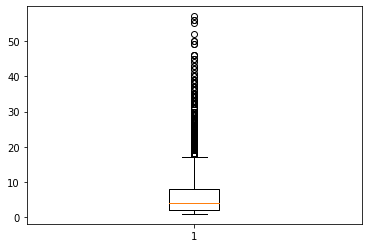

In [82]:
fig, ax = plt.subplots()

ax.boxplot([Session_len])

print('영화 당 클릭 수 Q1:', Session_len.quantile(0.25))
print('영화 당 클릭 수 Q2(중앙값):', Session_len.quantile(0.50))
print('영화 당 클릭 수 Q3:', Session_len.quantile(0.75))

한 세션 당 클릭한 영화의 수를 SessionId로 정의했을 때, 일반적으로 4~5개의 영화를 클릭하고 많게는 20개 정도를 클릭한다.

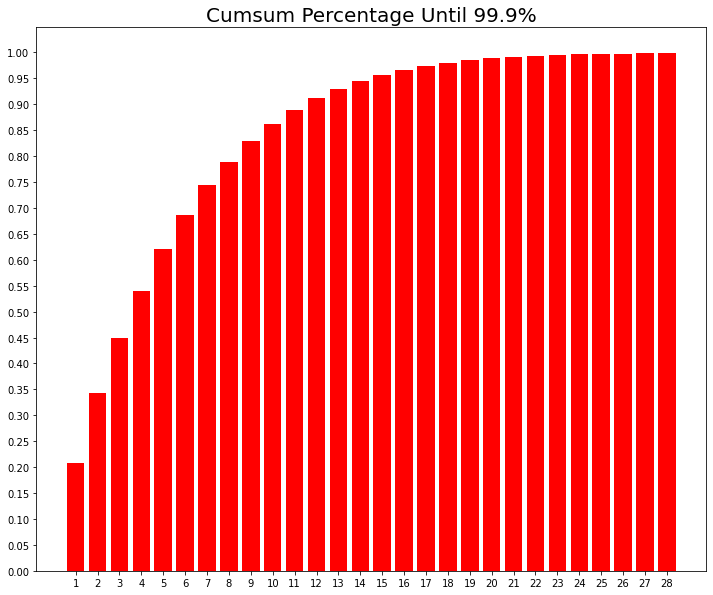

In [83]:
length_count = Session_len.groupby(Session_len).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 99.9%', size=20)
plt.show()

In [84]:
data_year_ago = data[data['Time'] > year_ago]
data_year_ago

,UserId,ItemId,Rating,Time,SessionId,Time_Unit
5333,36,1387,5,1015904819,968,8465873
5334,36,1201,4,1015904819,968,8465873
5335,36,1291,5,1015904836,968,8465873
5336,36,2167,5,1015904905,969,8465874
5337,36,2951,4,1015904905,969,8465874
...,...,...,...,...,...,...
992789,5996,3835,3,1020113184,182747,8500943
992790,5996,2422,3,1020113225,182747,8500943
992791,5996,168,3,1031058746,182748,8592156
992792,5996,339,4,1033997079,182749,8616642


In [85]:
data_cleanned = cleanse_recursive(data_year_ago, shortest=2, least_click=0)     # 클릭 수가 적어도 삭제하지 않음
data_cleanned

,UserId,ItemId,Rating,Time,SessionId,Time_Unit
5333,36,1387,5,1015904819,968,8465873
5334,36,1201,4,1015904819,968,8465873
5335,36,1291,5,1015904836,968,8465873
5336,36,2167,5,1015904905,969,8465874
5337,36,2951,4,1015904905,969,8465874
...,...,...,...,...,...,...
992786,5996,3716,3,1020112230,182745,8500935
992787,5996,2748,1,1020112352,182746,8500936
992788,5996,3564,3,1020112392,182746,8500936
992789,5996,3835,3,1020113184,182747,8500943


In [86]:
tr, test = split_by_date(data_cleanned, n_days=15)
tr, val = split_by_date(tr, n_days=15)

stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 15409
	 Sessions: 3761
	 Items: 2656
	 First Time : 1014923199
	 Last Time : 1043799175

* valid Set Stats Info
	 Events: 734
	 Sessions: 139
	 Items: 585
	 First Time : 1043823493
	 Last Time : 1045103679

* test Set Stats Info
	 Events: 469
	 Sessions: 121
	 Items: 408
	 First Time : 1045159762
	 Last Time : 1046454590



In [87]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [88]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [89]:
tr_dataset = SessionDataset(tr)
tr_dataset.df

,UserId,ItemId,Rating,Time,SessionId,Time_Unit,item_idx
5333,36,1387,5,1015904819,968,8465873,0
5334,36,1201,4,1015904819,968,8465873,1
5335,36,1291,5,1015904836,968,8465873,2
5336,36,2167,5,1015904905,969,8465874,3
5337,36,2951,4,1015904905,969,8465874,4
...,...,...,...,...,...,...,...
992786,5996,3716,3,1020112230,182745,8500935,2655
992787,5996,2748,1,1020112352,182746,8500936,2095
992788,5996,3564,3,1020112392,182746,8500936,2175
992789,5996,3835,3,1020113184,182747,8500943,1866


In [90]:
tr_dataset.click_offsets

array([    0,     3,    11, ..., 15405, 15407, 15409], dtype=int32)

In [91]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 3758, 3759, 3760])

In [92]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
iter_ex = iter(tr_data_loader)

In [93]:
args = Args(tr, val, test, batch_size=16, hsz=50, drop_rate=0.1, lr=0.001, epochs=50, k=20)
model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(16, 1, 2656)]           0         
_________________________________________________________________
GRU (GRU)                    [(16, 50), (16, 50)]      406200    
_________________________________________________________________
dropout_3 (Dropout)          (16, 50)                  0         
_________________________________________________________________
dense_3 (Dense)              (16, 2656)                135456    
Total params: 541,656
Trainable params: 541,656
Non-trainable params: 0
_________________________________________________________________


In [94]:
train_model(model, args)

Evaluation:  97%|█████████▋| 36/37 [00:03<00:00,  9.21it/s]


	 - Recall@20 epoch 1: 0.032986
	 - MRR@20    epoch 1: 0.007224



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.30it/s]


	 - Recall@20 epoch 2: 0.024306
	 - MRR@20    epoch 2: 0.006557



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.06it/s]


	 - Recall@20 epoch 3: 0.022569
	 - MRR@20    epoch 3: 0.007084



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.16it/s]


	 - Recall@20 epoch 4: 0.026042
	 - MRR@20    epoch 4: 0.008120



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.23it/s]


	 - Recall@20 epoch 5: 0.022569
	 - MRR@20    epoch 5: 0.007520



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.38it/s]


	 - Recall@20 epoch 6: 0.017361
	 - MRR@20    epoch 6: 0.006961



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.22it/s]


	 - Recall@20 epoch 7: 0.024306
	 - MRR@20    epoch 7: 0.006775



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.14it/s]


	 - Recall@20 epoch 8: 0.034722
	 - MRR@20    epoch 8: 0.008358



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.17it/s]


	 - Recall@20 epoch 9: 0.039931
	 - MRR@20    epoch 9: 0.010229



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.16it/s]


	 - Recall@20 epoch 10: 0.038194
	 - MRR@20    epoch 10: 0.014303



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.33it/s]


	 - Recall@20 epoch 11: 0.041667
	 - MRR@20    epoch 11: 0.016107



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.37it/s]


	 - Recall@20 epoch 12: 0.050347
	 - MRR@20    epoch 12: 0.018870



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.34it/s]


	 - Recall@20 epoch 13: 0.059028
	 - MRR@20    epoch 13: 0.023211



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.40it/s]


	 - Recall@20 epoch 14: 0.057292
	 - MRR@20    epoch 14: 0.024685



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.31it/s]


	 - Recall@20 epoch 15: 0.059028
	 - MRR@20    epoch 15: 0.027175



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.52it/s]


	 - Recall@20 epoch 16: 0.062500
	 - MRR@20    epoch 16: 0.027411



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.61it/s]


	 - Recall@20 epoch 17: 0.059028
	 - MRR@20    epoch 17: 0.024640



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.57it/s]


	 - Recall@20 epoch 18: 0.060764
	 - MRR@20    epoch 18: 0.025885



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.57it/s]


	 - Recall@20 epoch 19: 0.060764
	 - MRR@20    epoch 19: 0.025632



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.02it/s]


	 - Recall@20 epoch 20: 0.062500
	 - MRR@20    epoch 20: 0.025367



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.24it/s]


	 - Recall@20 epoch 21: 0.057292
	 - MRR@20    epoch 21: 0.024781



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.55it/s]


	 - Recall@20 epoch 22: 0.055556
	 - MRR@20    epoch 22: 0.024966



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.32it/s]


	 - Recall@20 epoch 23: 0.057292
	 - MRR@20    epoch 23: 0.023002



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.49it/s]


	 - Recall@20 epoch 24: 0.060764
	 - MRR@20    epoch 24: 0.023751



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.39it/s]


	 - Recall@20 epoch 25: 0.057292
	 - MRR@20    epoch 25: 0.023388



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.64it/s]


	 - Recall@20 epoch 26: 0.055556
	 - MRR@20    epoch 26: 0.022225



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.04it/s]


	 - Recall@20 epoch 27: 0.057292
	 - MRR@20    epoch 27: 0.022271



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.38it/s]


	 - Recall@20 epoch 28: 0.055556
	 - MRR@20    epoch 28: 0.021286



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.43it/s]


	 - Recall@20 epoch 29: 0.062500
	 - MRR@20    epoch 29: 0.023035



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.62it/s]


	 - Recall@20 epoch 30: 0.060764
	 - MRR@20    epoch 30: 0.022132



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.49it/s]


	 - Recall@20 epoch 31: 0.059028
	 - MRR@20    epoch 31: 0.021296



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.63it/s]


	 - Recall@20 epoch 32: 0.059028
	 - MRR@20    epoch 32: 0.022490



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.27it/s]


	 - Recall@20 epoch 33: 0.060764
	 - MRR@20    epoch 33: 0.022221



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.50it/s]


	 - Recall@20 epoch 34: 0.060764
	 - MRR@20    epoch 34: 0.021620



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.69it/s]


	 - Recall@20 epoch 35: 0.060764
	 - MRR@20    epoch 35: 0.021275



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.57it/s]


	 - Recall@20 epoch 36: 0.060764
	 - MRR@20    epoch 36: 0.022106



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.52it/s]


	 - Recall@20 epoch 37: 0.057292
	 - MRR@20    epoch 37: 0.021586



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.57it/s]


	 - Recall@20 epoch 38: 0.059028
	 - MRR@20    epoch 38: 0.023312



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.48it/s]


	 - Recall@20 epoch 39: 0.060764
	 - MRR@20    epoch 39: 0.021751



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00,  9.83it/s]


	 - Recall@20 epoch 40: 0.059028
	 - MRR@20    epoch 40: 0.021649



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.66it/s]


	 - Recall@20 epoch 41: 0.057292
	 - MRR@20    epoch 41: 0.023824



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.52it/s]


	 - Recall@20 epoch 42: 0.059028
	 - MRR@20    epoch 42: 0.023104



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.66it/s]


	 - Recall@20 epoch 43: 0.060764
	 - MRR@20    epoch 43: 0.022556



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.56it/s]


	 - Recall@20 epoch 44: 0.062500
	 - MRR@20    epoch 44: 0.021759



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.36it/s]


	 - Recall@20 epoch 45: 0.062500
	 - MRR@20    epoch 45: 0.021780



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.59it/s]


	 - Recall@20 epoch 46: 0.065972
	 - MRR@20    epoch 46: 0.020953



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.62it/s]


	 - Recall@20 epoch 47: 0.067708
	 - MRR@20    epoch 47: 0.022609



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.49it/s]


	 - Recall@20 epoch 48: 0.062500
	 - MRR@20    epoch 48: 0.019984



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.70it/s]


	 - Recall@20 epoch 49: 0.067708
	 - MRR@20    epoch 49: 0.019523



Evaluation:  97%|█████████▋| 36/37 [00:03<00:00, 10.42it/s]

	 - Recall@20 epoch 50: 0.069444
	 - MRR@20    epoch 50: 0.019677



Recall과 MRR 모두 1),2)에 비해 좋지 않은 성능을 보인다.

## 회고

* 추천서비스는 CV도 NLP도 아닌 다른 분야이고 가장 모호한 분야인듯 하다. 알고 싶은 분야이지만 자꾸 벽이 느껴진다....
* 데이터 구성에 있어 Session의 시간 길이 '1초'인 아주 짧은 단위를 만들었을 때 가장 성능이 좋았는데, 현실적으로 Session 시간 길이가 1초라는 건 다소 납득하기 어렵다. 모델 구조와 연관지어 생각해보면 Session의 시간 길이가 짧을 수록 한 Session 당 클릭한 영화의 수(Session len)가 짧아지고 그 점이 모델의 효율성을 높이는 데 기여할 것 같기도 하다. 하지만 그보다는 Session의 갯수가 약 47만개에서 약 18만개로 줄어든 탓이 더 크지 않을까 추측해본다.
* 마찬가지로 클릭 수가 1번밖에 없는 영화의 경우도 삭제하지 않는 것이 더 나은 것으로 보아 결국 데이터량이 일정 수준 이상 존재해야 하고, 가능한 한 지우지 않는 편이 나은 게 아니었을까. 추천시스템에서의 전처리는 쉽게 추측할 수가 없어 더 어렵게 느껴진다.